# Setup

In [61]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)



# Vanishing/Exploding Gradients Problem

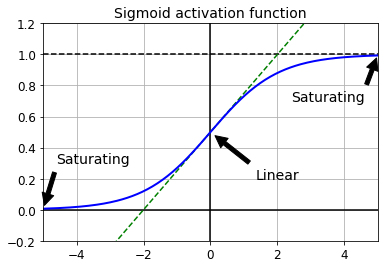

In [62]:
# The code below displays a plot showing how as the inputs increase in magnitude, the gradient reaches zero and the backpropogation correction for the weights doesn't work?

def logit(z):
    return 1 / (1 + np.exp(-z))



z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.savefig("sigmoid_saturation_plot")
plt.show()



# Xavier and HE Initialization

In [63]:
# There is a method to minimize the effects of the Vanishing/Exploding Gradients problem:
    # We need the signal to flow properly in both directions:
        # In the forward direction when making predictions
        # Backwards when backpropogating gradients.
    # We don't want the signal to die out, nor do we want it to explode and saturate..
        # In order for the signal to flow properly, we need the variance of the outputs of each layer to be equal to the variance of its inputs
        # The gradients should have equal variance after flowing through a layer in the reverse direction.
        # It's not possible to guarantee both unless the layer has an equal number of input and output connections.
        
# But there is a good compromise to allow the signal to flow properly: the connection weights must be initialized randomly.
# The Xavier initialization strategy can speed up training considerably.

# By default the tf.layers.dense() function uses Xavier initialization using the variance_scaling_initializer() function like this:

import tensorflow as tf

reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init, name="hidden1")



# Nonsaturating Activation Functions

In [64]:
# One of the insights about Vanishing/exploding gradients was that they were in part due to a poor choice of activation function.
# Until then most people assumed that since mother nature chose to use roughly sigmoid functions in biological neurons, this was an excellent choice.
# But it turns out that other activation functions work much better in deep neural networks :
    # An example if the ReLU function. It doesn't saturate for positive values and is fast to compute.
    
# However, ReLU isn't perfect. It suffers from a problem known as dying ReLUs: during training, some neurons stop outputting anything except 0.
# In some cases half the network's neurons are dead, especially with a high learning rate.
# To solve this problem we could use a variant of the ReLU called a leaking ReLU.
    # It makes it so the slope of the function when z<0 is typically set to 0.01  so that leaky ReLU never dies, it might just go to sleep.
# There are also randomized leaky ReLUs  where the learning rate alpha is picked randomly in a given range during training, and it is fixed to an average value during testing.

# It seems that large leaks where alpha is set to 0.2 performs better then alpha set to a small leak value of .01

# Next, there is something called a parametric leaky ReLU where alpha(the amount of leaking) is authorized to be learned during training.
    # Instead of being a hyperparameter, alpha(leak rate) can be modified by backpropagation like any other parameter.

# In 2015, a new activation function was proposed called an Exponential Linear Unit(ELU).
# There are a couple advantages to the ELU function:
    # It takes on negative values when z < 0 which allows the unit to have an average output close to o. This helps alleviate the vanishing gradients problem.
    # It has a nonzero gradient  for z < 0, which avoids the dying units issue.
    # Third if alpha is equal to  1 then the function is smooth everywhere, including around z=0, which helps speed up Gradient Descent, since it doesn't bounce as much left and right of z = 0.
    
# The main disadvantage of the ELU function is that it's slower to compute then the ReLU and its variants.



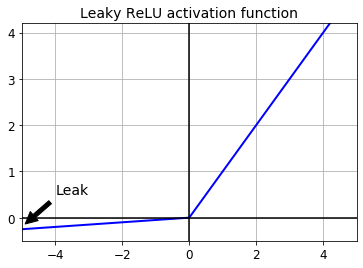

In [65]:
# The following code outputs a Leaky ReLU plot:

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.savefig("leaky_relu_plot")
plt.show()

In [66]:
# Implementing Leaky ReLU in TensorFlow:

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [67]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")


In [68]:
# Let's train a neural network on MNIST using the leaky ReLU. First let's create the graph:

reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
n_hidden2= 100
n_outputs = 10

In [69]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [70]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [71]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [72]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [73]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [74]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [75]:
# Let's load the data:

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [76]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [78]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)
            
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9048
5 Batch accuracy: 0.94 Validation accuracy: 0.9508
10 Batch accuracy: 0.92 Validation accuracy: 0.966
15 Batch accuracy: 1.0 Validation accuracy: 0.9724
20 Batch accuracy: 1.0 Validation accuracy: 0.9746
25 Batch accuracy: 0.98 Validation accuracy: 0.9762
30 Batch accuracy: 1.0 Validation accuracy: 0.9784
35 Batch accuracy: 1.0 Validation accuracy: 0.9788


# ELU

In [79]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

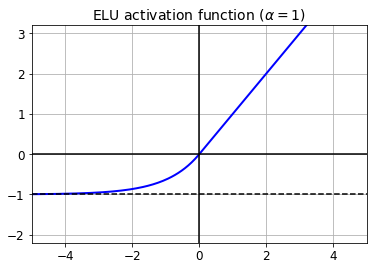

In [80]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.savefig("elu_plot")
plt.show()

In [81]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [82]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

# SELU

In [83]:
# SELU stands for Self-Normalizing Exponential Linear Unit. In a paper about this, it proposes that during training, a deep neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize.
# Self-normalization means that the output of each layer will tend to preserve the same mean and variance  during tranining.
    # This solves the vanishing/exploding gradients problem. As a result this activation significantly outperforms the other activation functions significantly.
# Unfortunately, the self-normalizing property of the SELU is easily broken when using nonsequential topologies?! 
    # If it is broken, SELU will perform no better then the other activation functions.
    
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [84]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)


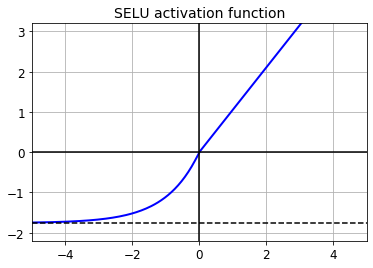

In [85]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.savefig("selu_plot")
plt.show()

In [86]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [87]:
def selu(z, scale=alpha_0_1, alpha=scale_0_1):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

# Note that the SELU activation function cannot be used along with regular Dropout.
# Fortunately there is a Dropout Variant called Alpha Dropout. It is available in tf.contrib.nn.alpha_dropout().

# Let's create a neural net for MNIST using the SELU activation function:

reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

In [88]:
# Now let's train it. Don't forget to scale the inputs to mean 0 and standard deviation 1:


means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.94 Validation accuracy: 0.9388
5 Batch accuracy: 0.98 Validation accuracy: 0.9634
10 Batch accuracy: 1.0 Validation accuracy: 0.9694
15 Batch accuracy: 1.0 Validation accuracy: 0.9706
20 Batch accuracy: 1.0 Validation accuracy: 0.9694
25 Batch accuracy: 1.0 Validation accuracy: 0.9696
30 Batch accuracy: 1.0 Validation accuracy: 0.9706
35 Batch accuracy: 1.0 Validation accuracy: 0.9706


# Batch Normalization

In [89]:
# Using HE initialization along with ELU (or any variant of ReLU) can significantly reduce the vanishing/exploding gradients problems at the beginning of training.
# However it doesn't guarantee that they won't come back during training.
# Batch normalization is extremely effective for Deep Neural Networks. The vanishing gradients problems was greatly reduced, even when using saturating functions such as tanh and logistic functions.
# Batch normalization is one of the best techniques for improving accuracy of ML models.
# One downside is that Batch Normalization does add some complexity to the model. There is a slower runtime for predictions.
# If you need predictions to be lightning fast, you might want to check how well plain Exponential Linear Unit Activation + HE Initialization perform before playing with Batch Normalization.

# TensorFlow provides a tf.nn.batch_normalization() function:

reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)



In [90]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')


In [91]:
# To avoid repeating the same parameters over and over again, we can use Python's partial() function.
# Repetition is a problem when having to program for many layers:

from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)


In [92]:
# Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

    

In [93]:
# Since we are using tf.layers.batch_normalization() rather than tf.contrib.layers.batch_norm() as in the book,
# we need to explicitly run the extra update operations needed by batch normalization(sess.run([training_op, extra_update_ops,...]))

n_epochs = 20
batch_size = 200

In [94]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                    feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9018
1 Validation accuracy: 0.9268
2 Validation accuracy: 0.939
3 Validation accuracy: 0.9462
4 Validation accuracy: 0.9502
5 Validation accuracy: 0.9532
6 Validation accuracy: 0.9608
7 Validation accuracy: 0.9628
8 Validation accuracy: 0.9654
9 Validation accuracy: 0.9678
10 Validation accuracy: 0.9686
11 Validation accuracy: 0.969
12 Validation accuracy: 0.9678
13 Validation accuracy: 0.971
14 Validation accuracy: 0.9712
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.9736
17 Validation accuracy: 0.9732
18 Validation accuracy: 0.9742
19 Validation accuracy: 0.9756


In [95]:
# For MNIST, this isn't great accuracy. The network is too shallow so Batch Norm and ELU are unlikely to have a very positive impact.
# Batch Norm and ELU do the best for much deeper nets.

# We could also make the training operation depend on the update operations. This way, you would just have to evaluate the training_op during training, Tensorflow would automatically run update operations as well.

# One more thing: notice that the list of trainable variables is shorter than the list of all global variables.
# This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network, you musn't forget these non-trainable variables.

[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [96]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

# Gradient Clipping

In [97]:
# A popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold.
# In general, people now prefer Batch Normalization, but it's still good to know Gradient Clipping.

# Let's create a simple neural net for MNIST and add gradient clipping:

reset_graph()

n_inputs = 28 * 28 #MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")




In [98]:
learning_rate = 0.01

In [99]:
# Now let's apply gradient clipping. For this, we need to get the gradients, use the clip_by_value() function to clip them, then we apply them:

threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [100]:
# The rest is the same as usual:

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [101]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [102]:
n_epochs = 20
batch_size = 200

In [103]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7936
2 Validation accuracy: 0.8798
3 Validation accuracy: 0.9062
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9218
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.9358
8 Validation accuracy: 0.9382
9 Validation accuracy: 0.9414
10 Validation accuracy: 0.9458
11 Validation accuracy: 0.947
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9536
14 Validation accuracy: 0.9566
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9578
17 Validation accuracy: 0.959
18 Validation accuracy: 0.9622
19 Validation accuracy: 0.9616


# Reusing a TensorFlow Model

In [104]:
# It's generally not a good idea to train a very large DNN from scratch. Better to find an existing neural network that performs a similar task to the one we're trying to tackle.
# Usually, we will try to reuse the lower level layers because they are more vague and general.
# If the original model was trained using TensorFlow, we can simply restore it and train it on a new rask.
# We can use the import_meta_graph() function to import the operations into a default graph. 
# This returns a Saver that you can later use to load the model's state:

reset_graph()

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [105]:
# Next we need to get a list of operations in that collection if we don't already know them:
# We'll usually have to do this if the pretrained model isn't well documented... We'll have to explore manually.

for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [106]:
# Once you know which operations you need, you can get a handle on them using the graph's get_operation_by_name() or get_tensor_by_name() methods:

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")




In [107]:
# If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them.
# Another approach is to create a collection containing all the important operations that people will want to get a handle on:

for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [108]:
# This way, people who reuse your model will be able to simply write:

X, y, accuracy, training_op = tf.get_collection("my_important_ops")

In [109]:
# Now we can start a session, restore the model's state and continue training on your data:

with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # Continue training the model...
    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [110]:
# Now let's test the model on real data:

with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    saver_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9644
1 Validation accuracy: 0.9628
2 Validation accuracy: 0.9652
3 Validation accuracy: 0.9654
4 Validation accuracy: 0.9644
5 Validation accuracy: 0.9652
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9688
8 Validation accuracy: 0.968
9 Validation accuracy: 0.9688
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9714
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.972
17 Validation accuracy: 0.9714
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9712


In [111]:
# Alternatively, you could have access to the Python code that built the original graph.
# We can use the original code instead of import_meta_graph().
# In general, we want to reuse only part of the original model, typically the lower layers.

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()


In [113]:
# Now we can train this new model that was created from reused parts of a preexisting NN:

with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9644
1 Validation accuracy: 0.9628
2 Validation accuracy: 0.9652
3 Validation accuracy: 0.9654
4 Validation accuracy: 0.9644
5 Validation accuracy: 0.9652
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9688
8 Validation accuracy: 0.968
9 Validation accuracy: 0.9688
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9714
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.972
17 Validation accuracy: 0.9714
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9712


In [114]:
# In general, we will want to reuse only the lower layers of the original model since it is the most basic and least specific part.
# If we use import_meta_graph(), it will load the whole graph, but we can simply ignore the parts we don't need.
# In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the 4th hidden layer).
# We also build a new output layer, the loss for this new output, and a new optimizer to minimize it.
# We also need another saver to save the whole graph, and initialization operation to initialize all the new variables:

reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()


In [115]:
# Now we can train this new model:

with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y: y_batch})
            accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Validation accuracy:", accuracy_val)
            
        save_path = new_saver.save(sess, "./my_new_model_final.ckpt")
            

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.1186
0 Validation accuracy: 0.1714
0 Validation accuracy: 0.1934
0 Validation accuracy: 0.2122
0 Validation accuracy: 0.2268
0 Validation accuracy: 0.2214
0 Validation accuracy: 0.2214
0 Validation accuracy: 0.2154
0 Validation accuracy: 0.2238
0 Validation accuracy: 0.2384
0 Validation accuracy: 0.2512
0 Validation accuracy: 0.278
0 Validation accuracy: 0.287
0 Validation accuracy: 0.2862
0 Validation accuracy: 0.3046
0 Validation accuracy: 0.3048
0 Validation accuracy: 0.3218
0 Validation accuracy: 0.3324
0 Validation accuracy: 0.3446
0 Validation accuracy: 0.3578
0 Validation accuracy: 0.3624
0 Validation accuracy: 0.3672
0 Validation accuracy: 0.379
0 Validation accuracy: 0.3864
0 Validation accuracy: 0.3942
0 Validation accuracy: 0.4026
0 Validation accuracy: 0.3978
0 Validation accuracy: 0.4066
0 Validation accuracy: 0.4148
0 Validation accuracy: 0.4094
0 Validation accuracy: 0.4108
0 Validat

1 Validation accuracy: 0.8972
1 Validation accuracy: 0.8974
1 Validation accuracy: 0.8966
1 Validation accuracy: 0.9002
1 Validation accuracy: 0.8972
1 Validation accuracy: 0.898
1 Validation accuracy: 0.899
1 Validation accuracy: 0.9022
1 Validation accuracy: 0.9022
1 Validation accuracy: 0.8992
1 Validation accuracy: 0.9008
1 Validation accuracy: 0.8994
1 Validation accuracy: 0.9026
1 Validation accuracy: 0.9008
1 Validation accuracy: 0.9012
1 Validation accuracy: 0.9016
1 Validation accuracy: 0.897
1 Validation accuracy: 0.899
1 Validation accuracy: 0.9042
1 Validation accuracy: 0.899
1 Validation accuracy: 0.8972
1 Validation accuracy: 0.8988
1 Validation accuracy: 0.902
1 Validation accuracy: 0.8988
1 Validation accuracy: 0.9016
1 Validation accuracy: 0.9032
1 Validation accuracy: 0.9044
1 Validation accuracy: 0.9058
1 Validation accuracy: 0.9028
1 Validation accuracy: 0.9016
1 Validation accuracy: 0.9054
1 Validation accuracy: 0.9054
1 Validation accuracy: 0.9014
1 Validation acc

2 Validation accuracy: 0.9262
2 Validation accuracy: 0.9274
2 Validation accuracy: 0.9274
2 Validation accuracy: 0.9272
2 Validation accuracy: 0.928
2 Validation accuracy: 0.9278
2 Validation accuracy: 0.9282
2 Validation accuracy: 0.927
2 Validation accuracy: 0.9272
2 Validation accuracy: 0.9268
2 Validation accuracy: 0.9274
2 Validation accuracy: 0.9264
2 Validation accuracy: 0.9294
2 Validation accuracy: 0.9298
2 Validation accuracy: 0.9294
2 Validation accuracy: 0.93
2 Validation accuracy: 0.9294
2 Validation accuracy: 0.9294
2 Validation accuracy: 0.9292
2 Validation accuracy: 0.93
2 Validation accuracy: 0.9298
2 Validation accuracy: 0.927
2 Validation accuracy: 0.9278
2 Validation accuracy: 0.9278
2 Validation accuracy: 0.9284
2 Validation accuracy: 0.927
2 Validation accuracy: 0.9286
2 Validation accuracy: 0.9294
2 Validation accuracy: 0.9264
2 Validation accuracy: 0.9278
2 Validation accuracy: 0.929
2 Validation accuracy: 0.9282
2 Validation accuracy: 0.9296
2 Validation accura

3 Validation accuracy: 0.9392
3 Validation accuracy: 0.9382
3 Validation accuracy: 0.939
3 Validation accuracy: 0.9384
3 Validation accuracy: 0.9384
3 Validation accuracy: 0.938
3 Validation accuracy: 0.939
3 Validation accuracy: 0.936
3 Validation accuracy: 0.9378
3 Validation accuracy: 0.9376
3 Validation accuracy: 0.9384
3 Validation accuracy: 0.9388
3 Validation accuracy: 0.9404
3 Validation accuracy: 0.9382
3 Validation accuracy: 0.9398
3 Validation accuracy: 0.9396
3 Validation accuracy: 0.9408
3 Validation accuracy: 0.9392
3 Validation accuracy: 0.938
3 Validation accuracy: 0.9384
3 Validation accuracy: 0.937
3 Validation accuracy: 0.9376
3 Validation accuracy: 0.938
3 Validation accuracy: 0.938
3 Validation accuracy: 0.939
3 Validation accuracy: 0.938
3 Validation accuracy: 0.9388
3 Validation accuracy: 0.9392
3 Validation accuracy: 0.9398
3 Validation accuracy: 0.9392
3 Validation accuracy: 0.9384
3 Validation accuracy: 0.9384
3 Validation accuracy: 0.9382
3 Validation accurac

4 Validation accuracy: 0.9444
4 Validation accuracy: 0.9446
4 Validation accuracy: 0.9442
4 Validation accuracy: 0.9442
4 Validation accuracy: 0.9436
4 Validation accuracy: 0.9464
4 Validation accuracy: 0.9458
4 Validation accuracy: 0.945
4 Validation accuracy: 0.944
4 Validation accuracy: 0.9458
4 Validation accuracy: 0.9456
4 Validation accuracy: 0.9438
4 Validation accuracy: 0.944
4 Validation accuracy: 0.9456
4 Validation accuracy: 0.9442
4 Validation accuracy: 0.9442
4 Validation accuracy: 0.946
4 Validation accuracy: 0.9454
4 Validation accuracy: 0.9448
4 Validation accuracy: 0.9442
4 Validation accuracy: 0.9464
4 Validation accuracy: 0.946
4 Validation accuracy: 0.9452
4 Validation accuracy: 0.9448
4 Validation accuracy: 0.9452
4 Validation accuracy: 0.9448
4 Validation accuracy: 0.9462
4 Validation accuracy: 0.946
4 Validation accuracy: 0.9466
4 Validation accuracy: 0.9446
4 Validation accuracy: 0.943
4 Validation accuracy: 0.9458
4 Validation accuracy: 0.9418
4 Validation accu

5 Validation accuracy: 0.9504
5 Validation accuracy: 0.9502
5 Validation accuracy: 0.9488
5 Validation accuracy: 0.95
5 Validation accuracy: 0.9494
5 Validation accuracy: 0.9502
5 Validation accuracy: 0.9498
5 Validation accuracy: 0.9502
5 Validation accuracy: 0.9502
5 Validation accuracy: 0.9482
5 Validation accuracy: 0.9498
5 Validation accuracy: 0.9508
5 Validation accuracy: 0.9504
5 Validation accuracy: 0.9488
5 Validation accuracy: 0.9498
5 Validation accuracy: 0.9504
5 Validation accuracy: 0.95
5 Validation accuracy: 0.9482
5 Validation accuracy: 0.9488
5 Validation accuracy: 0.951
5 Validation accuracy: 0.9492
5 Validation accuracy: 0.9506
5 Validation accuracy: 0.95
5 Validation accuracy: 0.9502
5 Validation accuracy: 0.952
5 Validation accuracy: 0.9498
5 Validation accuracy: 0.9496
5 Validation accuracy: 0.9494
5 Validation accuracy: 0.9486
5 Validation accuracy: 0.9496
5 Validation accuracy: 0.9488
5 Validation accuracy: 0.9508
5 Validation accuracy: 0.9504
5 Validation accur

6 Validation accuracy: 0.9532
6 Validation accuracy: 0.952
6 Validation accuracy: 0.9534
6 Validation accuracy: 0.9528
6 Validation accuracy: 0.953
6 Validation accuracy: 0.9528
6 Validation accuracy: 0.953
6 Validation accuracy: 0.952
6 Validation accuracy: 0.9528
6 Validation accuracy: 0.9532
6 Validation accuracy: 0.9548
6 Validation accuracy: 0.9526
6 Validation accuracy: 0.9518
6 Validation accuracy: 0.953
6 Validation accuracy: 0.954
6 Validation accuracy: 0.954
6 Validation accuracy: 0.953
6 Validation accuracy: 0.9536
6 Validation accuracy: 0.9532
6 Validation accuracy: 0.9532
6 Validation accuracy: 0.9536
6 Validation accuracy: 0.9538
6 Validation accuracy: 0.9536
6 Validation accuracy: 0.9542
6 Validation accuracy: 0.9542
6 Validation accuracy: 0.9544
6 Validation accuracy: 0.9536
6 Validation accuracy: 0.954
6 Validation accuracy: 0.9524
6 Validation accuracy: 0.9524
6 Validation accuracy: 0.9536
6 Validation accuracy: 0.9536
6 Validation accuracy: 0.9544
6 Validation accura

7 Validation accuracy: 0.9568
7 Validation accuracy: 0.958
7 Validation accuracy: 0.9568
7 Validation accuracy: 0.9576
7 Validation accuracy: 0.9578
7 Validation accuracy: 0.9586
7 Validation accuracy: 0.9578
7 Validation accuracy: 0.9566
7 Validation accuracy: 0.9558
7 Validation accuracy: 0.9564
7 Validation accuracy: 0.956
7 Validation accuracy: 0.9578
7 Validation accuracy: 0.957
7 Validation accuracy: 0.957
7 Validation accuracy: 0.9576
7 Validation accuracy: 0.9564
7 Validation accuracy: 0.9552
7 Validation accuracy: 0.9558
7 Validation accuracy: 0.9548
7 Validation accuracy: 0.9542
7 Validation accuracy: 0.9564
7 Validation accuracy: 0.9536
7 Validation accuracy: 0.958
7 Validation accuracy: 0.9576
7 Validation accuracy: 0.9566
7 Validation accuracy: 0.9566
7 Validation accuracy: 0.9554
7 Validation accuracy: 0.9566
7 Validation accuracy: 0.9558
7 Validation accuracy: 0.9556
7 Validation accuracy: 0.9558
7 Validation accuracy: 0.9576
7 Validation accuracy: 0.9568
7 Validation ac

8 Validation accuracy: 0.9596
8 Validation accuracy: 0.9598
8 Validation accuracy: 0.9598
8 Validation accuracy: 0.9584
8 Validation accuracy: 0.9596
8 Validation accuracy: 0.957
8 Validation accuracy: 0.9598
8 Validation accuracy: 0.9598
8 Validation accuracy: 0.9592
8 Validation accuracy: 0.9592
8 Validation accuracy: 0.9586
8 Validation accuracy: 0.9578
8 Validation accuracy: 0.9586
8 Validation accuracy: 0.9568
8 Validation accuracy: 0.9578
8 Validation accuracy: 0.9582
8 Validation accuracy: 0.9578
8 Validation accuracy: 0.9584
8 Validation accuracy: 0.958
8 Validation accuracy: 0.9594
8 Validation accuracy: 0.9586
8 Validation accuracy: 0.9592
8 Validation accuracy: 0.9596
8 Validation accuracy: 0.9578
8 Validation accuracy: 0.9576
8 Validation accuracy: 0.9584
8 Validation accuracy: 0.9596
8 Validation accuracy: 0.9594
8 Validation accuracy: 0.9588
8 Validation accuracy: 0.9586
8 Validation accuracy: 0.9584
8 Validation accuracy: 0.9596
8 Validation accuracy: 0.959
8 Validation 

9 Validation accuracy: 0.96
9 Validation accuracy: 0.9596
9 Validation accuracy: 0.9602
9 Validation accuracy: 0.9608
9 Validation accuracy: 0.96
9 Validation accuracy: 0.9588
9 Validation accuracy: 0.9594
9 Validation accuracy: 0.9592
9 Validation accuracy: 0.959
9 Validation accuracy: 0.9606
9 Validation accuracy: 0.9602
9 Validation accuracy: 0.9598
9 Validation accuracy: 0.9598
9 Validation accuracy: 0.9602
9 Validation accuracy: 0.9598
9 Validation accuracy: 0.9586
9 Validation accuracy: 0.9602
9 Validation accuracy: 0.9608
9 Validation accuracy: 0.9624
9 Validation accuracy: 0.9612
9 Validation accuracy: 0.9592
9 Validation accuracy: 0.9592
9 Validation accuracy: 0.959
9 Validation accuracy: 0.9598
9 Validation accuracy: 0.9602
9 Validation accuracy: 0.9594
9 Validation accuracy: 0.9596
9 Validation accuracy: 0.9594
9 Validation accuracy: 0.961
9 Validation accuracy: 0.961
9 Validation accuracy: 0.9608
9 Validation accuracy: 0.9604
9 Validation accuracy: 0.9606
9 Validation accur

10 Validation accuracy: 0.9624
10 Validation accuracy: 0.9626
10 Validation accuracy: 0.9614
10 Validation accuracy: 0.9612
10 Validation accuracy: 0.962
10 Validation accuracy: 0.961
10 Validation accuracy: 0.9624
10 Validation accuracy: 0.9626
10 Validation accuracy: 0.9622
10 Validation accuracy: 0.9614
10 Validation accuracy: 0.9574
10 Validation accuracy: 0.9616
10 Validation accuracy: 0.962
10 Validation accuracy: 0.9614
10 Validation accuracy: 0.9592
10 Validation accuracy: 0.9604
10 Validation accuracy: 0.9614
10 Validation accuracy: 0.9616
10 Validation accuracy: 0.961
10 Validation accuracy: 0.961
10 Validation accuracy: 0.9618
10 Validation accuracy: 0.9622
10 Validation accuracy: 0.9632
10 Validation accuracy: 0.9608
10 Validation accuracy: 0.9612
10 Validation accuracy: 0.9624
10 Validation accuracy: 0.961
10 Validation accuracy: 0.9608
10 Validation accuracy: 0.9626
10 Validation accuracy: 0.9636
10 Validation accuracy: 0.9624
10 Validation accuracy: 0.9614
10 Validation 

11 Validation accuracy: 0.963
11 Validation accuracy: 0.9624
11 Validation accuracy: 0.9628
11 Validation accuracy: 0.9616
11 Validation accuracy: 0.9614
11 Validation accuracy: 0.9632
11 Validation accuracy: 0.9634
11 Validation accuracy: 0.9632
11 Validation accuracy: 0.9632
11 Validation accuracy: 0.9622
11 Validation accuracy: 0.9618
11 Validation accuracy: 0.9624
11 Validation accuracy: 0.9634
11 Validation accuracy: 0.9632
11 Validation accuracy: 0.964
11 Validation accuracy: 0.962
11 Validation accuracy: 0.9626
11 Validation accuracy: 0.9632
11 Validation accuracy: 0.9646
11 Validation accuracy: 0.9634
11 Validation accuracy: 0.9628
11 Validation accuracy: 0.9642
11 Validation accuracy: 0.9626
11 Validation accuracy: 0.9616
11 Validation accuracy: 0.96
11 Validation accuracy: 0.9622
11 Validation accuracy: 0.9626
11 Validation accuracy: 0.962
11 Validation accuracy: 0.9612
11 Validation accuracy: 0.9612
11 Validation accuracy: 0.9628
11 Validation accuracy: 0.962
11 Validation a

12 Validation accuracy: 0.9632
12 Validation accuracy: 0.9642
12 Validation accuracy: 0.962
12 Validation accuracy: 0.9638
12 Validation accuracy: 0.9638
12 Validation accuracy: 0.964
12 Validation accuracy: 0.9634
12 Validation accuracy: 0.9624
12 Validation accuracy: 0.9642
12 Validation accuracy: 0.9648
12 Validation accuracy: 0.9654
12 Validation accuracy: 0.9646
12 Validation accuracy: 0.965
12 Validation accuracy: 0.9648
12 Validation accuracy: 0.964
12 Validation accuracy: 0.9642
12 Validation accuracy: 0.9626
12 Validation accuracy: 0.9632
12 Validation accuracy: 0.9642
12 Validation accuracy: 0.9656
12 Validation accuracy: 0.9646
12 Validation accuracy: 0.965
12 Validation accuracy: 0.9646
12 Validation accuracy: 0.9656
12 Validation accuracy: 0.9644
12 Validation accuracy: 0.965
12 Validation accuracy: 0.965
12 Validation accuracy: 0.9642
12 Validation accuracy: 0.9644
12 Validation accuracy: 0.9632
12 Validation accuracy: 0.9642
12 Validation accuracy: 0.9642
12 Validation a

13 Validation accuracy: 0.9636
13 Validation accuracy: 0.9634
13 Validation accuracy: 0.9618
13 Validation accuracy: 0.9642
13 Validation accuracy: 0.965
13 Validation accuracy: 0.9656
13 Validation accuracy: 0.9656
13 Validation accuracy: 0.9658
13 Validation accuracy: 0.9652
13 Validation accuracy: 0.9658
13 Validation accuracy: 0.9656
13 Validation accuracy: 0.9672
13 Validation accuracy: 0.967
13 Validation accuracy: 0.9664
13 Validation accuracy: 0.966
13 Validation accuracy: 0.9656
13 Validation accuracy: 0.9656
13 Validation accuracy: 0.9646
13 Validation accuracy: 0.9658
13 Validation accuracy: 0.9652
13 Validation accuracy: 0.9664
13 Validation accuracy: 0.9662
13 Validation accuracy: 0.9648
13 Validation accuracy: 0.9646
13 Validation accuracy: 0.9644
13 Validation accuracy: 0.964
13 Validation accuracy: 0.9658
13 Validation accuracy: 0.9654
13 Validation accuracy: 0.9648
13 Validation accuracy: 0.965
13 Validation accuracy: 0.9654
13 Validation accuracy: 0.9658
13 Validation

13 Validation accuracy: 0.9666
14 Validation accuracy: 0.9648
14 Validation accuracy: 0.9646
14 Validation accuracy: 0.966
14 Validation accuracy: 0.9674
14 Validation accuracy: 0.9664
14 Validation accuracy: 0.9646
14 Validation accuracy: 0.9664
14 Validation accuracy: 0.966
14 Validation accuracy: 0.9656
14 Validation accuracy: 0.9656
14 Validation accuracy: 0.9666
14 Validation accuracy: 0.9664
14 Validation accuracy: 0.9664
14 Validation accuracy: 0.9654
14 Validation accuracy: 0.9654
14 Validation accuracy: 0.967
14 Validation accuracy: 0.966
14 Validation accuracy: 0.9658
14 Validation accuracy: 0.9654
14 Validation accuracy: 0.9654
14 Validation accuracy: 0.9686
14 Validation accuracy: 0.968
14 Validation accuracy: 0.9664
14 Validation accuracy: 0.9662
14 Validation accuracy: 0.9668
14 Validation accuracy: 0.9666
14 Validation accuracy: 0.9674
14 Validation accuracy: 0.967
14 Validation accuracy: 0.964
14 Validation accuracy: 0.9648
14 Validation accuracy: 0.9658
14 Validation a

14 Validation accuracy: 0.9688
14 Validation accuracy: 0.9678
14 Validation accuracy: 0.967
14 Validation accuracy: 0.9686
14 Validation accuracy: 0.9672
14 Validation accuracy: 0.9674
14 Validation accuracy: 0.9666
14 Validation accuracy: 0.966
15 Validation accuracy: 0.9676
15 Validation accuracy: 0.9666
15 Validation accuracy: 0.9666
15 Validation accuracy: 0.9682
15 Validation accuracy: 0.9678
15 Validation accuracy: 0.9684
15 Validation accuracy: 0.967
15 Validation accuracy: 0.968
15 Validation accuracy: 0.968
15 Validation accuracy: 0.9672
15 Validation accuracy: 0.9676
15 Validation accuracy: 0.9672
15 Validation accuracy: 0.9672
15 Validation accuracy: 0.9662
15 Validation accuracy: 0.967
15 Validation accuracy: 0.9644
15 Validation accuracy: 0.9656
15 Validation accuracy: 0.9658
15 Validation accuracy: 0.9662
15 Validation accuracy: 0.966
15 Validation accuracy: 0.9648
15 Validation accuracy: 0.9658
15 Validation accuracy: 0.967
15 Validation accuracy: 0.9658
15 Validation ac

15 Validation accuracy: 0.9676
15 Validation accuracy: 0.9686
15 Validation accuracy: 0.9686
15 Validation accuracy: 0.9676
15 Validation accuracy: 0.9658
15 Validation accuracy: 0.9656
15 Validation accuracy: 0.9666
15 Validation accuracy: 0.9666
15 Validation accuracy: 0.9652
15 Validation accuracy: 0.9672
15 Validation accuracy: 0.966
15 Validation accuracy: 0.967
16 Validation accuracy: 0.9682
16 Validation accuracy: 0.9684
16 Validation accuracy: 0.9682
16 Validation accuracy: 0.9684
16 Validation accuracy: 0.9688
16 Validation accuracy: 0.9688
16 Validation accuracy: 0.9676
16 Validation accuracy: 0.9668
16 Validation accuracy: 0.968
16 Validation accuracy: 0.9674
16 Validation accuracy: 0.968
16 Validation accuracy: 0.9678
16 Validation accuracy: 0.9686
16 Validation accuracy: 0.9672
16 Validation accuracy: 0.9668
16 Validation accuracy: 0.9682
16 Validation accuracy: 0.9666
16 Validation accuracy: 0.967
16 Validation accuracy: 0.967
16 Validation accuracy: 0.9668
16 Validation 

16 Validation accuracy: 0.968
16 Validation accuracy: 0.968
16 Validation accuracy: 0.967
16 Validation accuracy: 0.966
16 Validation accuracy: 0.9658
16 Validation accuracy: 0.9672
16 Validation accuracy: 0.9672
16 Validation accuracy: 0.9642
16 Validation accuracy: 0.9648
16 Validation accuracy: 0.9644
16 Validation accuracy: 0.966
16 Validation accuracy: 0.9664
16 Validation accuracy: 0.9672
16 Validation accuracy: 0.9662
16 Validation accuracy: 0.9678
16 Validation accuracy: 0.9678
16 Validation accuracy: 0.9678
16 Validation accuracy: 0.9678
16 Validation accuracy: 0.9676
17 Validation accuracy: 0.9674
17 Validation accuracy: 0.9674
17 Validation accuracy: 0.9646
17 Validation accuracy: 0.965
17 Validation accuracy: 0.9642
17 Validation accuracy: 0.965
17 Validation accuracy: 0.9672
17 Validation accuracy: 0.9672
17 Validation accuracy: 0.9668
17 Validation accuracy: 0.9666
17 Validation accuracy: 0.9666
17 Validation accuracy: 0.967
17 Validation accuracy: 0.9676
17 Validation ac

17 Validation accuracy: 0.967
17 Validation accuracy: 0.9682
17 Validation accuracy: 0.968
17 Validation accuracy: 0.9692
17 Validation accuracy: 0.969
17 Validation accuracy: 0.9692
17 Validation accuracy: 0.9672
17 Validation accuracy: 0.965
17 Validation accuracy: 0.9684
17 Validation accuracy: 0.969
17 Validation accuracy: 0.9688
17 Validation accuracy: 0.9692
17 Validation accuracy: 0.97
17 Validation accuracy: 0.9658
17 Validation accuracy: 0.9694
17 Validation accuracy: 0.9698
17 Validation accuracy: 0.9698
17 Validation accuracy: 0.9688
17 Validation accuracy: 0.9682
17 Validation accuracy: 0.9694
17 Validation accuracy: 0.9696
17 Validation accuracy: 0.9672
17 Validation accuracy: 0.9676
17 Validation accuracy: 0.9678
17 Validation accuracy: 0.9652
17 Validation accuracy: 0.9666
18 Validation accuracy: 0.9674
18 Validation accuracy: 0.9678
18 Validation accuracy: 0.968
18 Validation accuracy: 0.968
18 Validation accuracy: 0.968
18 Validation accuracy: 0.9676
18 Validation accu

18 Validation accuracy: 0.9688
18 Validation accuracy: 0.9684
18 Validation accuracy: 0.9682
18 Validation accuracy: 0.9676
18 Validation accuracy: 0.9678
18 Validation accuracy: 0.9674
18 Validation accuracy: 0.9672
18 Validation accuracy: 0.9656
18 Validation accuracy: 0.9696
18 Validation accuracy: 0.9686
18 Validation accuracy: 0.969
18 Validation accuracy: 0.9686
18 Validation accuracy: 0.9692
18 Validation accuracy: 0.9682
18 Validation accuracy: 0.9692
18 Validation accuracy: 0.9686
18 Validation accuracy: 0.9684
18 Validation accuracy: 0.9688
18 Validation accuracy: 0.968
18 Validation accuracy: 0.9684
18 Validation accuracy: 0.969
18 Validation accuracy: 0.9688
18 Validation accuracy: 0.9704
18 Validation accuracy: 0.9694
18 Validation accuracy: 0.97
18 Validation accuracy: 0.9698
18 Validation accuracy: 0.966
18 Validation accuracy: 0.9672
18 Validation accuracy: 0.9682
18 Validation accuracy: 0.969
18 Validation accuracy: 0.9682
18 Validation accuracy: 0.968
18 Validation ac

19 Validation accuracy: 0.9694
19 Validation accuracy: 0.969
19 Validation accuracy: 0.9688
19 Validation accuracy: 0.9686
19 Validation accuracy: 0.9692
19 Validation accuracy: 0.969
19 Validation accuracy: 0.9672
19 Validation accuracy: 0.9672
19 Validation accuracy: 0.9676
19 Validation accuracy: 0.9686
19 Validation accuracy: 0.9692
19 Validation accuracy: 0.9696
19 Validation accuracy: 0.9688
19 Validation accuracy: 0.9672
19 Validation accuracy: 0.9668
19 Validation accuracy: 0.969
19 Validation accuracy: 0.9706
19 Validation accuracy: 0.9696
19 Validation accuracy: 0.969
19 Validation accuracy: 0.97
19 Validation accuracy: 0.9702
19 Validation accuracy: 0.9702
19 Validation accuracy: 0.9696
19 Validation accuracy: 0.9682
19 Validation accuracy: 0.97
19 Validation accuracy: 0.9694
19 Validation accuracy: 0.9696
19 Validation accuracy: 0.9692
19 Validation accuracy: 0.9682
19 Validation accuracy: 0.9688
19 Validation accuracy: 0.9686
19 Validation accuracy: 0.9684
19 Validation ac

In [116]:
# If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

reset_graph()

n_inputs = 28 * 28 #MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50 # reused
n_hidden3 = 50 # reused
n_hidden4 = 20 # new
n_outputs = 10 # new

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y= tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1") # Reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name= "hidden2") # Reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name= "hidden3") # Reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name= "hidden4") #New
    logits = tf.layers.dense(hidden4, n_outputs,name= "outputs") # New
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [118]:
# However, you must create one Saver to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another Saver to save the new model, once it is trained:
# The following code restores only hidden layers 1, 2, and 3:

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]") # regular expression

restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch,y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9
1 Validation accuracy: 0.9318
2 Validation accuracy: 0.9416
3 Validation accuracy: 0.9468
4 Validation accuracy: 0.9494
5 Validation accuracy: 0.953
6 Validation accuracy: 0.956
7 Validation accuracy: 0.9568
8 Validation accuracy: 0.959
9 Validation accuracy: 0.9616
10 Validation accuracy: 0.9602
11 Validation accuracy: 0.9636
12 Validation accuracy: 0.965
13 Validation accuracy: 0.966
14 Validation accuracy: 0.9646
15 Validation accuracy: 0.966
16 Validation accuracy: 0.967
17 Validation accuracy: 0.9676
18 Validation accuracy: 0.9662
19 Validation accuracy: 0.9682


In [119]:
# In summary, first we build the new model, making sure to copy the original model's hidden layers 1 to 3.
# Then we get the list of all variables in hidden layers 1 to 3, using the regular expression "hidden[123]".
# Next we create a dictionary that maps the name of each variable in the original model to its name in the new model(generally you want to keep the exact same names).
# Then we create a Saver that will restore only these variables.
# We also create an operation to initialize all the variables(old and new) and a second Saver to save the entire new model, not just layers 1-3.
# We then start a session and initialize all variables in the model, then restore the variable values from the original model's layers 1-3.
# Finally, we train the model on the new task and save it.

# Reusing Models from Other Frameworks

In [120]:
# If the model was trained using another framework, you will need to load the model parameters manually, then assign them to appropriate variables.
# This can be quite tedious. The following code shows how you would copy the weight and biases from the first hidden layer of a model trained using a different framework.

# In this example, for each variable we want to reuse, we will findits initializer's assignment operation, and we get its second input, which corresponds to the initialization value.
# When we run the initializer, we replace the initialization values with the ones we want, using feed_dict:

reset_graph()

n_inputs = 2
n_hidden1 = 3

In [121]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights and biases from the other framework.
original_b = [7., 8., 9.] # Load the weights and biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


In [122]:
# In the above implementation, we first load the pretrained model using the other framework.
# Then we extract from it model parameters we wanr to reuse. 
# Then we build our Tensorflow Model as usual.
# The tricky part is that every Tensorflow Variable has an associated assignment operation that is used to intialize it.
# We start by getting a handle on these assignment operations. We also get a handle on each assignment's handle input.
# Blah.... Blah.... Blah... Read page 294

In [123]:
# Note that for the previous code, the weights variable created by the tf.layers.dense() function is called "kernel" instead of "weights", when using the tf.contrib.layers.fully_connected().
# Also the biases variable is called bias instead of biases/

# Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this method more explicit:

reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.] # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer_hidden1
with tf.variable_scope("", default_name="", reuse=True): # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")
    
# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases =tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))


[[ 61.  83. 105.]]


In [124]:
# Note that we could also get a handle on the variables using get_collection() and specifying the scope:

tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

In [125]:
# Or we could use the graph's get_tensor_by_name() method:

tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [126]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

# Freezing the Lower Layers

In [130]:
# Let's create the old image classification network to work with in this section
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [132]:
# It is likely that the lower layers of the first DNN have learned to detect low-level features in pictures that will be useful across both image classification tasks, so you can just reuse these layers as they are.
# It is generally a good idea to "freeze" their weights when training the new DNN: if the lower layers are frozen, it will be easier to train the higher level layers.

# To freeze the lower layers during training, one solution is to give the optimizer the list of variables to train, excluding variables from the lower layers:

with tf.name_scope("train"): # Not shown in the book.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) # Not shown in the book.
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)
    
    # train_vars gets the list of all trainable variables in hidden layers 3 & 4 and the output layer. This leaves out hidden layers 1 and 2.
    # Next we provide this restricted list of trainable variables to the optimizer's minimize( function().
    # Now Layers 1 & 2 are frozen.

# Caching the Frozen Layers

In [133]:
# Since the frozen layers won't change, it is possible to cache the output of the topmost frozen layer for each training instance.
# Since training goes throug the dataset many times, this will provide a huge speed boost as you will only need to go through the frozen layers once per training instance (Instead of once per epoch).

# First let's create the first Deep Neural Network for MNIST:

reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50 # reused
n_hidden3 = 50 # reused
n_hidden4 = 20 # new!
n_outputs = 10 # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1") # Reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused frozen and cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [134]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [139]:
# We can run the whole training set through the lower layers, then during training, instead of building batches of training instances, you would build batches of outputs from hidden layer 2 and feed them to the training op:

import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # Not shown in the book
    
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})
            
        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, y: y_valid})
        
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_new_model_final.ckpt")
    
# The last line of the training loop runs the training operation defined earlier, and feeds it a batch of outputs from the second hidden layer.

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9004
1 Validation accuracy: 0.9328
2 Validation accuracy: 0.9438
3 Validation accuracy: 0.9486
4 Validation accuracy: 0.951
5 Validation accuracy: 0.9516
6 Validation accuracy: 0.9532
7 Validation accuracy: 0.9546
8 Validation accuracy: 0.9548
9 Validation accuracy: 0.9556
10 Validation accuracy: 0.9566
11 Validation accuracy: 0.9566
12 Validation accuracy: 0.9574
13 Validation accuracy: 0.957
14 Validation accuracy: 0.958
15 Validation accuracy: 0.9574
16 Validation accuracy: 0.9588
17 Validation accuracy: 0.9578
18 Validation accuracy: 0.9584
19 Validation accuracy: 0.9588


# Faster Optimizers

In [140]:
# Training a very large deep neural network can be painfully slow.
# So far we've seen four ways to speed up training:
    # Applying a good initialization strategy for the connection wieghts.
    # Using Batch Normalization
    # Reusing Parts of a pretrained network.

# Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer.
# In this section we will present the most popular ones: 
    # Momentum Optimization
    # Nesterov Accelerated Gradient
    # AdaGrad
    # RMSProp
    # Adam Optimization
    


# Momentum Optimization

In [141]:
# Gradient Descent will take small regular steps down the slope.
# Momentum Optimization will start out slowly, but will pick up momentum until it reaches terminal velocity.

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

# Nesterov Accelerated Gradient

In [142]:
# Nesterov Accelerated Gradient is a small variant of Momentum Optimization.
# The idea is to measure the gradient of the cost function, not at the local position slightly ahead in the direction of the momentum.
# This small tweak works because in general the momentum vector will be pointing in the right direction, so it will be slightly more accurate to use the gradient measured a bit further in that direction, rather then using the gradient at the original position.

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)

# AdaGrad

In [143]:
# Consider the elongated bowl problem again: Gradient Descent starts quickly going down the steepest slope, then slowly down the bottom of the valley.
# It would be nice if the algorithm could detect this early on and correct its direction to point a bit more toward the global optimum.
# The AdaGrad Algorithm achieves this by scaling down the gradient vector along the steepest dimensions.

optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

# RMSProp

In [144]:
# Although AdaGrad slows down a bit too fast and ends up never converging to the global optimum...
# The RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations(as opposed to all the gradients since the beginning of training).
# It does so using exponential decay in the first step.

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9, decay=0.9, epsilon=1e-10)

# Adam Optimization

In [145]:
# Adam stands for Adaptive Moment Estimation. It combines the ideas of Momentum optimization and RMSProp:
    # Just like Momentum Optimization it keeps track of an exponentially decaying average of past gradients
    # Just like RMSProp it keeps track of an exponentially decaying average of past SQUARED gradients.
    
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
# Since the Adam Optimizer is an adaptive learning rate algorithm, it requires less tuning of the learning rate  hyperparameter.
# We can often use the default hyperparameter value of .001, making Adam even easier to use than GradientDescent` 

# Learning Rate Scheduling

In [146]:
# Finding a good learning rate can be tricky.
    # If you set it too high, training might actually diverge.
    # If you set it too low, training will eventually converge to the optimum, but it will take a very long time.
    
# In order to get around this issue, we can avoid using a constant learning rate: start with a high learning rate and then reduce it once it stops making fast progress.
    # There are many techniques to implement this non-constant learning rate. They are called learning schedules.
    # The most common learning schedule techniques are:
        # Predetermined piecewise constant learning rate
        # Performance Scheduling
        # Exponential Scheduling
        # Power Scheduling

# Implementing a learning schedule with tensorflow is relatively straightforward.
# First, let's create a NN Model:

reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [147]:
# The Code below implements the Learning Rate Scheduling Algorithm  as well as training optimizer:

with tf.name_scope("train"):
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [148]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [149]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")
            
    

0 Validation accuracy: 0.9656
1 Validation accuracy: 0.9736
2 Validation accuracy: 0.9728
3 Validation accuracy: 0.9818
4 Validation accuracy: 0.9818


# Avoiding Overfitting Through Regularization

In [150]:
# Deep Neural Networks typically have tens of thousands of parameters, sometimes millions.
# With so many parameters, the network has an incredible amount of freedom and can fit a huge variety of complex datasets.
# But this great flexibility can lead to overfitting datasets.
# Therefore, we need to Regularize the Network using some of these techniques in TensorFlow:
    # Early Stopping
    # l1 and l2 regularization
    # Dropout
    # Max-norm regularization
    # Data augmentation

# Early Stopping

In [151]:
# Early stopping is to just interrupt training when its performance  on the validation set starts dropping.
# In Tensorflow, a method is to evaluate the model on a validation set at regular intervals, and save a "winner" snapshot if it outperforms previous winners.
# Count the number of steps since the last "winner" snapshot was saved, and interrupt training when this number reaches some limit.
# Then restore the last "Winner" snapshot.

# Although early stopping works well in practice, you can usually get much higher performance out of your network by combining it with other regularization techniques.



# l1 and l2 regularization

In [152]:
# This is a technique just like in Chapter 4, where you constrain a neural network's connection weights.
# In TensorFlow, one way to do this is to add the appropriate regularization terms to your cost function.

# For example, assuming you have just one hidden layer (for simplicity) with weights W1 and one output layer with weights W2, then you apply l1 regularization like this:

reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

In [153]:
# Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the l1 loss(i.e, the absolute values of the weights):

W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel: 0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel: 0")

scale = 0.001 #l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

In [154]:
# The rest is just as usual:

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [155]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9068
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


In [156]:
# Alternatively, we can pass a regularization function to the tf.layers.dense() function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses.
# The beginning is the same as above:

reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [157]:
# Next, we will use Python's partial() function to avoid repeating the same arguments over and over again. 
# Note that we set the kernel_regularizer argument:

scale = 0.01

In [158]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None, name="outputs")

In [159]:
# Next we must add the regularization losses to the base loss:

with tf.name_scope("loss"): # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [160]:
# And the rest is the same as usual:

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [161]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "/my_model_final.ckpt")

0 Validation accuracy: 0.7798
1 Validation accuracy: 0.7804
2 Validation accuracy: 0.6812
3 Validation accuracy: 0.5668
4 Validation accuracy: 0.5456
5 Validation accuracy: 0.5728
6 Validation accuracy: 0.6352
7 Validation accuracy: 0.6708
8 Validation accuracy: 0.6948
9 Validation accuracy: 0.7138
10 Validation accuracy: 0.7272
11 Validation accuracy: 0.7392
12 Validation accuracy: 0.7508
13 Validation accuracy: 0.7606
14 Validation accuracy: 0.7662
15 Validation accuracy: 0.771
16 Validation accuracy: 0.7792
17 Validation accuracy: 0.7854
18 Validation accuracy: 0.7876
19 Validation accuracy: 0.7942


PermissionDeniedError: /my_model_final.ckpt.data-00000-of-00001.tempstate5434930490947277620; Permission denied
	 [[Node: save/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/SaveV2/tensor_names, save/SaveV2/shape_and_slices, hidden1/bias, hidden1/kernel, hidden2/bias, hidden2/kernel, outputs/bias, outputs/kernel)]]

Caused by op 'save/SaveV2', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/lam/ml/env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/lam/ml/env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/lam/ml/env/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/lam/ml/env/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/lam/ml/env/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/lam/ml/env/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/lam/ml/env/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/lam/ml/env/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/lam/ml/env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/lam/ml/env/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/lam/ml/env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/lam/ml/env/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/lam/ml/env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/lam/ml/env/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/lam/ml/env/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/lam/ml/env/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/lam/ml/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/lam/ml/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/lam/ml/env/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/lam/ml/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/lam/ml/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/lam/ml/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-160-a353622630da>", line 14, in <module>
    saver = tf.train.Saver()
  File "/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1218, in __init__
    self.build()
  File "/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 748, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 296, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 239, in save_op
    tensors)
  File "/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1163, in save_v2
    shape_and_slices=shape_and_slices, tensors=tensors, name=name)
  File "/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/lam/ml/env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

PermissionDeniedError (see above for traceback): /my_model_final.ckpt.data-00000-of-00001.tempstate5434930490947277620; Permission denied
	 [[Node: save/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/SaveV2/tensor_names, save/SaveV2/shape_and_slices, hidden1/bias, hidden1/kernel, hidden2/bias, hidden2/kernel, outputs/bias, outputs/kernel)]]


# Dropout

In [162]:
# This is the most popular regularization technique for deep neural networks. Even state of the art NN got a 1-2% accuracy boost simply by adding dropout.
# Tha algorithm is fairly simple: at every training step, every neuron (including the input neurons but excluding the output neurons) has a probability p of being temporarily "dropped out"
# Being "dropped out" means the Neuron will be entirely ignored during the next step.
# The hyperparameter p is called the dropout rate, and is typically set to %50.
# After training, neurons don't get dropped anymore.

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [163]:
# To implement dropout in TensorFlow,we use tf.layers.dropout():

training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5 # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [164]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss =tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()
    
    

In [165]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")
        

0 Validation accuracy: 0.9254
1 Validation accuracy: 0.9452
2 Validation accuracy: 0.9492
3 Validation accuracy: 0.9566
4 Validation accuracy: 0.9618
5 Validation accuracy: 0.9608
6 Validation accuracy: 0.9598
7 Validation accuracy: 0.9674
8 Validation accuracy: 0.9698
9 Validation accuracy: 0.9714
10 Validation accuracy: 0.969
11 Validation accuracy: 0.9674
12 Validation accuracy: 0.971
13 Validation accuracy: 0.97
14 Validation accuracy: 0.9722
15 Validation accuracy: 0.9698
16 Validation accuracy: 0.973
17 Validation accuracy: 0.9724
18 Validation accuracy: 0.973
19 Validation accuracy: 0.9732


# Max-Norm Regularization

In [166]:
# For each neuron, it constrains the weights w of the incoming connectionssuch that the absolute value of w is less then r.
# r is the max-norm hyperparameter. Reducing r increases the amount of regularization and helps reduce overfitting.
# Max-norm regularization can also help alleviate the vanishing/exploding gradients problems(if you aren't using Batch Normalization).
# TensorFlow doesn't provide an off-the-shelf max-norm regularizer, but its not too hard to regularize:
# The following code gets a handle on the weights of the first hidden layer, then uses the clip_by_norm() function to create an operation that will clip the weights along the second axis so that each row vector ends up with a maximum norm of 1.0.


reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [168]:
# Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the clip_by_norm() function.
# Then we create an assignment operation to asign the clipped weights to the weights variable:

threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

In [169]:
# We can do this as well for the second hidden layer:

weights2 = tf.get_default_graph(). get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [170]:
# Let's add an initializer and a saver:

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [171]:
# And now we can train the model. It's pretty much as usual, except that right after running the training_op, we run the clip_weights2 operations:

n_epochs = 20
batch_size = 50

In [173]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()
            
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", acc_valid)
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9566
1 Validation accuracy: 0.9706
2 Validation accuracy: 0.9724
3 Validation accuracy: 0.9762
4 Validation accuracy: 0.9762
5 Validation accuracy: 0.9768
6 Validation accuracy: 0.9808
7 Validation accuracy: 0.9818
8 Validation accuracy: 0.9806
9 Validation accuracy: 0.9816
10 Validation accuracy: 0.982
11 Validation accuracy: 0.9838
12 Validation accuracy: 0.9816
13 Validation accuracy: 0.9838
14 Validation accuracy: 0.9844
15 Validation accuracy: 0.9842
16 Validation accuracy: 0.9834
17 Validation accuracy: 0.9838
18 Validation accuracy: 0.9838
19 Validation accuracy: 0.9846


In [179]:
# The implementation above is straightforward and works fine, but it is a bit messy. 
# A better approach is to define a max_norm_regularizer() function:

def max_norm_regularizer(threshold, axes=1, name="max_norm", collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm
    

In [180]:
# Then you can call this function to get a max norm regularizer(with the threshold you want).
# When you create a hiden layer, you can pass this regularizer to the kernel_regularizer argument:

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [181]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [182]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [183]:
# Training is as usual, except you must run the weights clipping operations after each training operation:

n_epochs = 20
batch_size=50

In [184]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation Accuracy:", acc_valid)
    save_path = saver.save(sess, "./my_model_final.ckt")

0 Validation Accuracy: 0.9588
1 Validation Accuracy: 0.9716
2 Validation Accuracy: 0.97
3 Validation Accuracy: 0.9778
4 Validation Accuracy: 0.9746
5 Validation Accuracy: 0.9804
6 Validation Accuracy: 0.9812
7 Validation Accuracy: 0.9796
8 Validation Accuracy: 0.9816
9 Validation Accuracy: 0.9814
10 Validation Accuracy: 0.9832
11 Validation Accuracy: 0.9846
12 Validation Accuracy: 0.9812
13 Validation Accuracy: 0.984
14 Validation Accuracy: 0.9834
15 Validation Accuracy: 0.9842
16 Validation Accuracy: 0.9842
17 Validation Accuracy: 0.9836
18 Validation Accuracy: 0.984
19 Validation Accuracy: 0.9842
